In [1]:
import numpy as np
import scipy
from scipy import sparse
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
import a_mps
import b_model
import c_tebd
import tfi_exact
import model_fopra
from scipy.fft import ifft, fftfreq
from scipy.linalg import svd

# DAY 1

### Exercise 1

In [2]:
L = 14
sigmaz = [[1,0],[0,-1]]
sigmax = [[0,1],[1,0]]

psi_up = a_mps.init_spinup_MPS(L)
print(psi_up.site_expectation_value(sigmaz))
print(psi_up.site_expectation_value(sigmax))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [3]:
def init_spinx_MPS(L):
    B = np.zeros([1, 2, 1], np.float)
    B[0, 0, 0] = 1/np.sqrt(2)
    B[0, 1, 0] = 1/np.sqrt(2)
    S = np.ones([1], np.float)
    Bs = [B.copy() for i in range(L)]
    Ss = [S.copy() for i in range(L)]
    return a_mps.MPS(Bs, Ss)

In [4]:
psi_x = init_spinx_MPS(L)
print(psi_x.site_expectation_value(sigmaz))
print(psi_x.site_expectation_value(sigmax))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


<ipython-input-3-01a139f663f6>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  B = np.zeros([1, 2, 1], np.float)
<ipython-input-3-01a139f663f6>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = np.ones([1], np.float)


In [5]:
J = 1
for g in [0.5,1,1.5]:
    H_ising = b_model.TFIModel(14,1,g)
    E_z_up = H_ising.energy(psi_up)
    E_x_up = H_ising.energy(psi_x)

    print('For g = ',g,', the energies are:', E_z_up, E_x_up)

For g =  0.5 , the energies are: -7.0 -12.999999999999996
For g =  1 , the energies are: -14.0 -12.999999999999996
For g =  1.5 , the energies are: -21.0 -12.999999999999996


In [9]:
g = 1.5
E, psi, model = c_tebd.example_TEBD_gs_finite(L, J, g)

finite TEBD, (imaginary time evolution)
L=14, J=1.0, g=1.50
dt = 0.10000: E = -23.1210722544100
dt = 0.01000: E = -23.2133644786914
dt = 0.00100: E = -23.2220037685472
dt = 0.00010: E = -23.2228606166766
dt = 0.00001: E = -23.2229463553360
final bond dimensions:  [2, 4, 8, 13, 17, 18, 18, 18, 17, 13, 8, 4, 2]


### Exercise 2

In [6]:
def correlation(psi_gs, opi, opj, i):
    
    Len = psi_gs.L
    assert i<Len
    
    correl = []
    
    theta = psi_gs.get_theta1(i) #Contracts Lambda i with B i  
    
    # i == j:   
    opi_opj = np.tensordot(opi,opj, axes=[0,1]) # i i* , j j* = i* j
    opi_opj = np.transpose(opi_opj) # = j i*
    theta_opi_opj = np.tensordot(theta,opi_opj,axes = ([1],[1])) # = vL vR j
    theta_opi_opj = np.transpose(theta_opi_opj, axes = (0,2,1))
    
    C = np.tensordot(theta_opi_opj, theta.conj(), axes = ([0,1,2],[0,1,2]))
    correl.append(C)
    
    #i<j:
    
    theta_opi = np.tensordot(theta,opi,axes = ([1],[1])) #vL i vR, i i* = vl vr i
    theta_opi=np.transpose(theta_opi, (0,2,1))
    L = np.tensordot(theta_opi, theta.conj(), axes = ([0,1],[0,1])) # [vL] [i] vR , [vL*] [i*] vR* = vR vR*
    
    for j in range(int(i+1), int(Len)):
        Bj = psi_gs.Bs[j] #vL j vR
        Bj_opj = np.tensordot(Bj,opj,axes = ([1],[1])) # = vL vR j
        Bj_opj = np.transpose(Bj_opj, (0,2,1)) # = vL j vR
        
        L_Bj_opj = np.tensordot(L,Bj_opj,axes = ([0],[0])) # = vR* j vR
        C = np.tensordot(L_Bj_opj,Bj.conj(),axes = ([0,1,2],[0,1,2]))
        correl.append(C)
        
        #Update L
        L_Bj = np.tensordot(L,Bj,axes=([0],[0]))# = vR* j vR
        L = np.tensordot(L_Bj,Bj.conj(),axes = ([0,1],[0,1])) # = vR vR*
    return np.real_if_close(correl)

In [8]:
L = 30
gs = [0.3, 0.5, 0.8, 0.9, 1, 1.1, 1.2, 1.5]
corrs = []
for g in gs:
    E, psi, model = c_tebd.example_TEBD_gs_finite(L, J, g)
    corrs.append(correlation(psi, model.sigmax, model.sigmax, L//4))

finite TEBD, (imaginary time evolution)
L=30, J=1.0, g=0.30
dt = 0.10000: E = -29.7237778057965
dt = 0.01000: E = -29.7243442589172
dt = 0.00100: E = -29.7244030096187
dt = 0.00010: E = -29.7244089062471
dt = 0.00001: E = -29.7244094959373
final bond dimensions:  [2, 4, 8, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 12, 8, 4, 2]
finite TEBD, (imaginary time evolution)
L=30, J=1.0, g=0.50
dt = 0.10000: E = -31.0307109228222
dt = 0.01000: E = -31.0351587180616
dt = 0.00100: E = -31.0356104605838
dt = 0.00010: E = -31.0356557268945
dt = 0.00001: E = -31.0356602537848
final bond dimensions:  [2, 4, 8, 14, 18, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 18, 14, 8, 4, 2]
finite TEBD, (imaginary time evolution)
L=30, J=1.0, g=0.80
dt = 0.10000: E = -34.3536078657672
dt = 0.01000: E = -34.3864798964379
dt = 0.00100: E = -34.3896367076687
dt = 0.00010: E = -34.3899515282532
dt = 0.00001: E = -34.3899830153060
final bond

Text(0.5, 0, 'g')

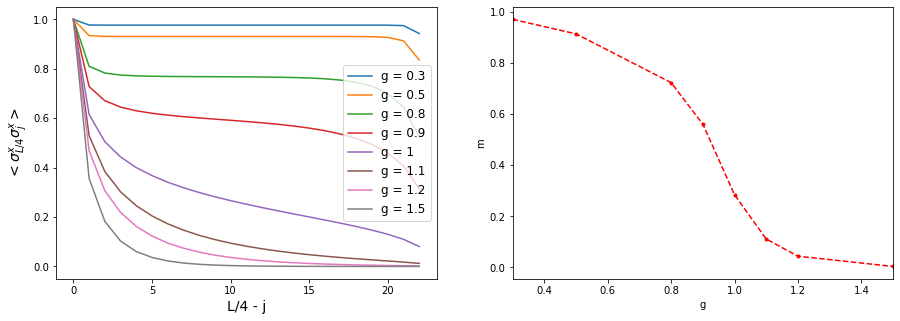

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
for i,g in enumerate(gs):
    ax1.plot(corrs[i],label = 'g = '+str(g))
    ax1.legend()
    ax1.set_xlabel('L/4 - j', fontsize = 14)
    ax1.set_ylabel('$< \sigma^x_{L/4} \sigma^x_j > $', fontsize = 14)
    ax1.legend(fontsize=12)
    #ax1.set_xticks()
    #ax1.set_yticks()
    # plt.grid(True)
    
ax2.plot(gs, np.sqrt(np.array(corrs)[:,-1]), '.--',color = 'red')
ax2.set_xlim(gs[0], gs[-1])  
ax2.set_ylabel('m')
ax2.set_xlabel('g')    
    

# DAY 2

#### Some functions we will use

In [7]:
def colorplot(xs, ys, data, **kwargs):
    """Create a colorplot with matplotlib.pyplot.imshow.

    Parameters
    ----------
    xs : 1D array, shape (n,)
        x-values of the points for which we have data; evenly spaced
    ys : 1D array, shape (m,)
        y-values of the points for which we have data; evenly spaced
    data : 2D array, shape (m, n)
        ``data[i, j]`` corresponds to the points ``(xs[i], ys[j])``
    **kwargs :
        additional keyword arguments, given to `imshow`.
    """
    data = np.asarray(data)
    if data.shape != (len(xs), len(ys)):
        raise ValueError("Shape of data doesn't match len of xs and ys!")
    dx = (xs[-1] - xs[0])/(len(xs)-1)
    print(dx)
    assert abs(dx - (xs[1]-xs[0])) < 1.e-5
    dy = (ys[-1] - ys[0])/(len(ys)-1)
    assert abs(dy - (ys[1]-ys[0])) < 1.e-5
    extent = (xs[0] - 0.5 * dx, xs[-1] + 0.5 * dx,  # left, right
              ys[0] - 0.5 * dy, ys[-1] + 0.5 * dy)  # bottom, top
    kwargs.setdefault('aspect', 'auto')
    kwargs.setdefault('interpolation', 'nearest')
    kwargs.setdefault('extent', extent)
    # convention of imshow: matrix like data[row, col] with (0, 0) top left.
    # but we want data[col, row] with (0, 0) bottom left -> transpose and invert y axis
    plt.imshow(data.T[::-1, :], **kwargs)
    

In [8]:
def TLFIM_TEBD_gs_finite(L, J, g, h):
    print("finite TEBD, (imaginary time evolution)")
    print("L={L:d}, J={J:.1f}, g={g:.2f}".format(L=L, J=J, g=g))
    import a_mps
    import b_model
    model = model_fopra.TLIFModel(L, J=J, g=g, h=h)
    psi = a_mps.init_spinup_MPS(L)
    for dt in [0.1, 0.01, 0.001, 1.e-4, 1.e-5]:
        U_bonds = c_tebd.calc_U_bonds(model, dt)
        c_tebd.run_TEBD(psi, U_bonds, N_steps=500, chi_max=30, eps=1.e-10)
        E = model.energy(psi)
        print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))
    print("final bond dimensions: ", psi.get_chi())
    if L < 20:  # for small systems compare to exact diagonalization
        E_exact = tfi_exact.finite_gs_energy(L, 1., g)
        print("Exact diagonalization: E = {E:.13f}".format(E=E_exact))
        print("relative error: ", abs((E - E_exact) / E_exact))
    return E, psi, model

In [9]:
def apply_op(psi, op, i):
    psi_aux = np.tensordot(op, psi.Bs[i], axes=[1,1]) # i [i*], vL [i] vR = i vL vR
    psi_aux = np.transpose(psi_aux, axes=[1,0,2]) # vL i vR
    return psi_aux

In [10]:
def overlap(mps_bra, mps_ket):
    L = len(mps_bra)
    assert L == len(mps_ket)
    contr = np.ones((1,1)) # has indices (alpha_n*, alpha_n), which we label vR* vR
    for n in range(L):
        M_ket = mps_ket[n]  # has indices (alpha_n, j_n, alpha_{n+1}) -> vL j vR
        contr = np.tensordot(contr, M_ket , axes=(1, 0)) # vR* [vR], [vL] j vR contract indices in []
        # now contr has indices vR* j vR
        M_bra = mps_bra[n].conj()  # vL* j* vR*
        contr = np.tensordot(M_bra, contr, axes=([0, 1], [0, 1])) # [vL*] [j*] vR*, [vR*] [j] vR
    assert contr.shape == (1, 1)
    return contr.item()

### a) Function for correlation functions in time

In [11]:
def time_correlation(psi_gs, model, E0, opi, opj, i,t_final, dt):
    
    L = psi_gs.L
    assert i < L
    
    t = np.arange(0,t_final,dt)
    S = []
    C = np.zeros([L, len(t)],dtype=complex)
    
    # ket
    psi_ket = psi_gs.copy()
    psi_ket.Bs[i] = apply_op(psi_ket, opi, i)
    
    # bra
    psi_bra = psi_gs.copy()
    
    # parameters and variables for TEBD
    U_bonds_real = c_tebd.calc_U_bonds(model, 1j*dt) # real time evolution
    chi_max = 100
    eps=1.e-10
    
    for n in range(len(t)):
        
        c_tebd.run_TEBD(psi_ket, U_bonds_real, 1, chi_max, eps) # evolve the new state Y|psi>
        S.append(psi_ket.entanglement_entropy())
        

        #Building LP (no operator there, contraction bra-ket)_________________
        theta0_ket = psi_ket.get_theta1(0) #vL i vR
        theta0_bra = psi_bra.get_theta1(0) #vL* i* vR*
        
        LP = np.tensordot(theta0_ket, theta0_bra.conj(), axes = ([0,1],[0,1])) # [vL] [i] vR , [vL*] [i*] vR* = vR vR*
        
        #______________________________
        
        #Building LP: 
        for k in range(1, i):
            #print('LP bbuilding k: ',k)
            LP = np.tensordot(LP, psi_ket.Bs[k], axes = ([0],[0])) #[vR] vR*, [vL] i vR = vR* , i, vR
            LP = np.tensordot(LP, psi_bra.Bs[k].conj(), axes = ([0,1],[0,1])) # [VR*], [i], VR, [vL*] [i*] vR* = vR vR*
        
        #______________________________
        
        #Building RP: List of different RP______________________
        RP_list = []
        RP_list.append(1)
        RP = np.tensordot(psi_ket.Bs[L-1], psi_bra.Bs[L-1].conj(), axes = ([1,2],[1,2])) # = vL [i] [vR], vL* [i*] [vR*] = vL , vL*
        RP_list.append(RP)
        
        for k in range(L-2,i, -1): 
            #print('k=', k)
            RP = np.tensordot(RP, psi_ket.Bs[k], axes = ([0],[2])) # = [vL] vL*, vL i [vR] = vL* vL i
            RP = np.tensordot(RP, psi_bra.Bs[k].conj(), axes = ([0,2],[2,1])) #  [vL*] vL [i], vL* [i*] [vR*] = vL vL*
            RP_list.append(RP)
         
        #_________________________________________
        aux = 1
        for j in range(int(i), int(L)):
            
            RP = RP_list[-aux]
            aux += 1
            
            Bjket = psi_ket.Bs[j] #vL j vR
            Bjbra = psi_bra.Bs[j].conj() #vL* j* vR*
            
            Bjket_opj = np.tensordot(Bjket,opj,axes = ([1],[1])) # vL [j] vR, j [j*]= vL vR j
            Bjket_opj = np.transpose(Bjket_opj, (0,2,1)) # = vL j vR
            LP_Bjket_opj = np.tensordot(LP,Bjket_opj,axes = ([0],[0])) # =[VR] vR*, [vL] j vR = vR* j vR
            
            if j == L-1:
                correl = np.tensordot(LP_Bjket_opj, Bjbra, axes = ([0,1,2],[0,1,2])) #[vR*][j][vR], [vL*][j*][vR*]
                
            else:
                LP_t = np.tensordot(LP_Bjket_opj, Bjbra, axes = ([0,1],[0,1])) #[vR*] [j] vR, [vL*] [j*] vR* =vR vR*
                correl = np.tensordot(LP_t,RP,axes = ([0,1],[0,1])) #[vR] [vR*], [vL] [vL*]
            
            #store corr
            C[i-(j-i),n] = correl*np.exp(1j*E0*dt*n)
            C[j,n] = correl*np.exp(1j*E0*dt*n)
            
            #Update L
            LP = np.tensordot(LP,Bjket,axes=([0],[0]))# = [vR] vR*, [vL] j vR = vR* j vL
            LP = np.tensordot(LP,Bjbra,axes = ([0,1],[0,1])) # = vR vR*
            
    return C, S

__Quick Test__

In [300]:
# defining the model and computing the ground state
L = 50
g = 2
J = 1
E, psi, model = c_tebd.example_TEBD_gs_finite(L, J, g)

finite TEBD, (imaginary time evolution)
L=50, J=1.0, g=2.00
dt = 0.10000: E = -105.7113662726242
dt = 0.01000: E = -106.1727069458336
dt = 0.00100: E = -106.2178652998994
dt = 0.00010: E = -106.2223598067640
dt = 0.00001: E = -106.2228096272322
final bond dimensions:  [2, 4, 8, 12, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 12, 8, 4, 2]


In [15]:
sigmay = np.array([[0, -1j],[1j, 0]])


In [14]:
# time dependent correlation

t_final = 10
dt=0.05
sigma=5

sigmay = np.array([[0, -1j],[1j, 0]])

corrs = []
C_positive, S = time_correlation(psi, model, E, sigmay, sigmay, L//2, t_final, dt)

(200, 49)
(49,)
1.0


(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

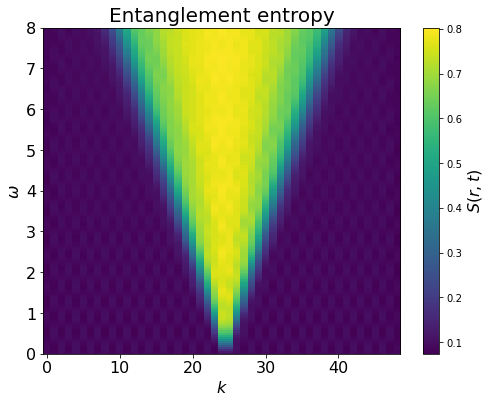

In [316]:
plt.figure(figsize=(8, 6))
t = np.arange(0,t_final,dt)
r = np.arange(0, len(S[1]), 1)
print(np.array(S).shape)
print(r.shape)
colorplot(r, t, np.array(S).T)
plt.xlabel("r", fontsize=16)
plt.ylabel("t", fontsize=16)
plt.colorbar().set_label("$S(r, t)$", fontsize=16)
plt.title("Entanglement entropy", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#### b) Function for  Fourier Transform in space and Time

#### Two versions of Fourier transform (1. using fft, 2. explicit) 

In [317]:
def fourier_space_time(C_positive, t_final, dt, L, sigma):
    #print(C_positive.shape)
    C = []
    for j in range(L):
        C_negative = np.conj(C_positive[j])
        C_negative = C_negative[::-1]
        C.append(np.concatenate((C_positive[j],C_negative))) # this concatenation order might seem off but it is right for fft 
        
    C=np.array(C)
    #print(C.shape)
    t1 = np.arange(-t_final,t_final,dt)
    
        
    # gaussian envelope
    t = np.arange(0,t_final,dt)
    C_gauss = []
    #sigma = 5
    gauss1 = np.exp(-0.5*(2*t/len(t1)*sigma)**2)
    gauss2 = gauss1[::-1]
    gauss = np.concatenate((gauss1,gauss2))

    for j in range(L):
        C_gauss.append(np.multiply(C[j], gauss))
    
    fig, (ax1, ax3) = plt.subplots(1,2, figsize=(15, 5))
    ax1.plot(t1, abs(np.array(C)[L//2]), label='No Gauss')
    ax1.plot(t1, abs(C_gauss[L//2]), label='Gauss')
    ax1.set_xlabel('time')
    ax1.set_ylabel('C(i=j, t)')
    ax1.legend()
        
    # Fourier transform in space
    k_array = np.arange(-L//2, L//2+0.5, 1) * 2*np.pi/L
    C_Fourier_space = np.zeros((len(t1), len(k_array)), dtype=complex)

    for i,k in enumerate(k_array):
        Fourier_bin = np.zeros(len(t1), dtype= complex)
        for j in range(-L//2, L//2):
            Fourier_bin += C_gauss[j+L//2] * np.exp(1j*k*j) / np.sqrt(L)
        C_Fourier_space[:,i] = Fourier_bin 
    
    for i in [0, 50, 80]:
        ax3.plot(k_array, abs(C_Fourier_space[i,:]), marker='o', linestyle='-', label="$t={i0}$".format(i0=i*0.05))

    ax3.set_xlabel('$k$')
    ax3.set_ylabel('Correlation $iG(k)$')
    ax3.legend()
    
        
    # Fourier transform in time
    N = 2*int(t_final/dt) # sample points   # 2* for the concatenate
    T = dt # sample spacing
    xf = fftfreq(N,T)[:N//2] # only positive freq
    xf = xf*2*np.pi
    C_Fourier = np.zeros((N//2, len(k_array)), dtype=complex)

    for i in range(len(k_array)):
        yf = ifft(C_Fourier_space[:,i]) 
        C_Fourier[:,i] = yf[0:N//2] * np.sqrt(N//2)
            
    return t1, k_array, xf, C, C_gauss, C_Fourier_space, C_Fourier
    

In [ ]:
def fourier_space_time_2(C, t_final, dt, L, sigma):
    #print(C_positive.shape)
    
    
    C=np.array(C)
    #print(C.shape)
        
    # gaussian envelope
    t = np.arange(0,t_final,dt)
    C_gauss = []
    #sigma = 5
    gauss1 = np.exp(-0.5*((t/(len(t)*sigma))**2))

    for j in range(L):
        C_gauss.append(np.multiply(C[j], gauss1))
    C_gauss=np.array(C_gauss)
    
    fig, (ax1, ax3) = plt.subplots(1,2, figsize=(15, 5))
    ax1.plot(t, abs(np.array(C)[L//2]), label='No Gauss')
    ax1.plot(t, abs(C_gauss[L//2]), label='Gauss')
    ax1.set_xlabel('time')
    ax1.set_ylabel('C(i=j, t)')
    ax1.legend()
    
    ax3.plot(t, abs(np.array(C)[L//2+1]), label='No Gauss')
    ax3.plot(t, abs(C_gauss[L//2+1]), label='Gauss')
    ax3.set_xlabel('time')
    ax3.set_ylabel('C(j=i+1, t)')
    ax3.legend()
                    
    # Fourier transform in time
    ome_array = np.arange(0, 10, 0.001)
    C_Fourier_time = np.zeros((L, len(ome_array)), dtype=complex)
    for i,ome in enumerate(ome_array):
        Fourier_bin_t = np.zeros(L, dtype= complex)
        for j in range(len(t)):
            Fourier_bin_t += np.real(C_gauss[:,j] * np.exp(1j*ome*t[j]) / (2*np.pi))*dt
        C_Fourier_time[:,i] = Fourier_bin_t 
        
        
    # Fourier transform in space
    k_array = np.arange(-L//2, L//2+0.5, 1) * 2*np.pi/L
    C_Fourier_space = np.zeros((len(ome_array), len(k_array)), dtype=complex)

    for i,k in enumerate(k_array):
        Fourier_bin = np.zeros(len(ome_array), dtype= complex)
        for j in range(-L//2, L//2):
            Fourier_bin += C_Fourier_time[j+L//2] * np.exp(-1j*k*j) / np.sqrt(L)
        C_Fourier_space[:,i] = Fourier_bin 
    
            
    return t, k_array, ome_array, C_gauss, C_Fourier_time, C_Fourier_space
    

#### Test for Fourier 

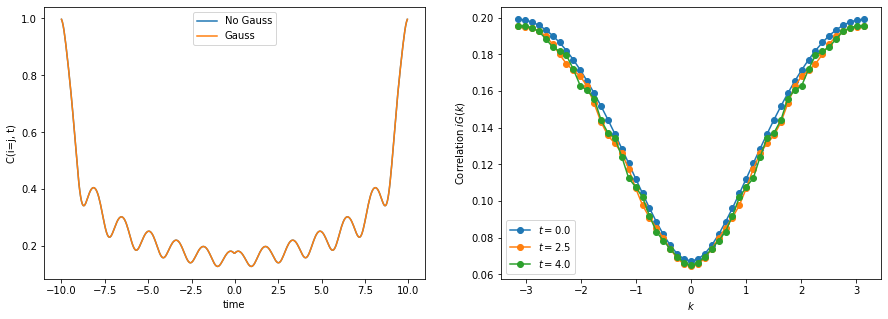

In [230]:
sigma=0.05
t1, k_array, xf, C, C_gauss, C_Fourier_space, C_Fourier = fourier_space_time(C_positive, t_final, dt, L, sigma)

0.12566370614359174


(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

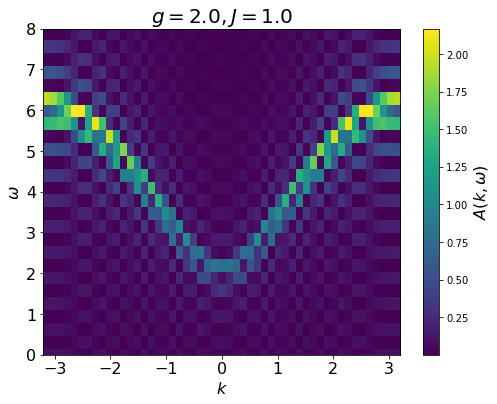

In [233]:
plt.figure(figsize=(8, 6))
colorplot(k_array, xf, abs(np.real(C_Fourier.T)))
plt.xlabel("$k$", fontsize=16)
plt.ylabel("$\\omega$", fontsize=16)
plt.colorbar().set_label("$A(k, \\omega)$", fontsize=16)
plt.title("$g={g:.1f}, J={J:.1f}$".format(g=g, J=J), fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Numerical Results

### c.1) g=2, J=1, h=0, L=50, t=10 --- Paramagnetic Phase

In [72]:
L=50
J=1
g=2
h=0
t_final=10
sigma = 0.5 

E, psi, model = TLFIM_TEBD_gs_finite(L, J, g, h)

finite TEBD, (imaginary time evolution)
L=50, J=1.0, g=2.00
dt = 0.10000: E = -105.7113662726242
dt = 0.01000: E = -106.1727069458336
dt = 0.00100: E = -106.2178652998994
dt = 0.00010: E = -106.2223598067640
dt = 0.00001: E = -106.2228096272322
final bond dimensions:  [2, 4, 8, 12, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 12, 8, 4, 2]


In [73]:
sigmay = np.array([[0, -1j],[1j, 0]])

dt=0.02

C_positive, S = time_correlation(psi, model, E, sigmay, sigmay, L//2, t_final, dt)

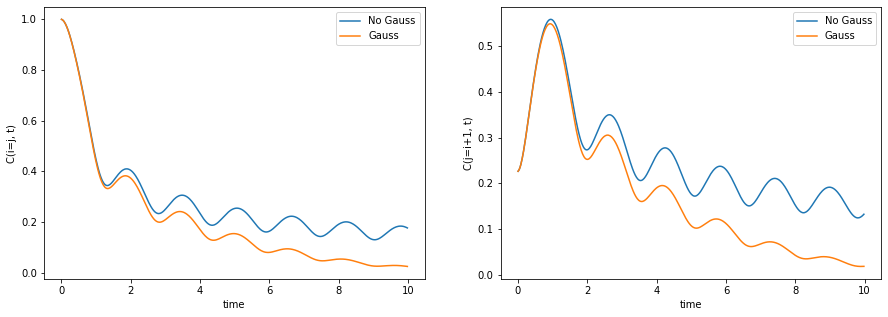

In [74]:
sigma=0.01 # strong gauss needed to kill Gibbs Oscillations
t, k_array, ome_array, C_gauss, C_Fourier_time, C_Fourier_space = fourier_space_time_2(C_positive, t_final, dt, L, sigma)

0.12566370614359174


(array([-2.,  0.,  2.,  4.,  6.,  8., 10.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

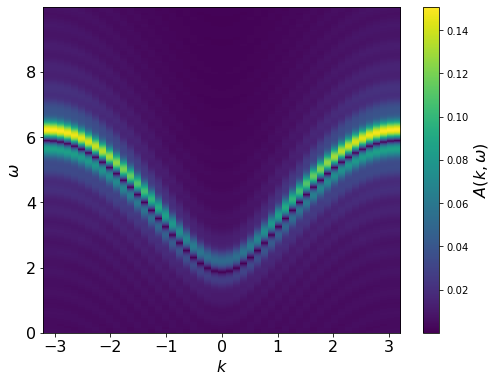

In [75]:
plt.figure(figsize=(8, 6))
colorplot(k_array, ome_array, abs((C_Fourier_space.T)))
plt.xlabel("$k$", fontsize=16)
plt.ylabel("$\\omega$", fontsize=16)
plt.colorbar().set_label("$A(k, \\omega)$", fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

(50, 500)
(50,)
1.0


(array([-2.,  0.,  2.,  4.,  6.,  8., 10.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

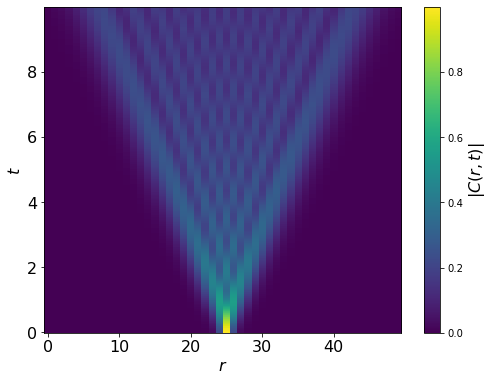

In [80]:
plt.figure(figsize=(8, 6))
t = np.arange(0,t_final,dt)
r = np.arange(0, len(S[1])+1, 1)
print(np.array(C_positive).shape)
print(r.shape)
colorplot(r, t, np.array(abs((C_positive))))
plt.xlabel("$r$", fontsize=16)
plt.ylabel("$t$", fontsize=16)
plt.colorbar().set_label("$|C(r, t)|$", fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [ ]:
plt.figure(figsize=(8, 6))
t = np.arange(0,t_final,dt)
r = np.arange(0, len(S[1]), 1)
print(np.array(S).shape)
print(r.shape)
colorplot(r, t, np.array(S).T)
plt.xlabel("$i$", fontsize=16)
plt.ylabel("$t$", fontsize=16)
plt.colorbar().set_label("$S(r, t)$", fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

### c.1) g=0.2, J=1, h=0, L=30, t=25   --- Ordered Phase

In [63]:
L=30
J=1
g=0.19
h=0
dt=0.02
t_final=25
sigma = 0.1 

E, psi, model = TLFIM_TEBD_gs_finite(L, J, g, h)

finite TEBD, (imaginary time evolution)
L=30, J=1.0, g=0.19
dt = 0.10000: E = -29.2893979016764
dt = 0.01000: E = -29.2894885210255
dt = 0.00100: E = -29.2894979795318
dt = 0.00010: E = -29.2894989293049
dt = 0.00001: E = -29.2894990242863
final bond dimensions:  [2, 4, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 4, 2]


In [64]:

sigmay = np.array([[0, -1j],[1j, 0]])
sigmax = np.array([[0, 1],[1, 0]])
sigmaz=  np.array([[1, 0],[0, -1]])
C_positive, S = time_correlation(psi, model, E, sigmay, sigmay, L//2, t_final, dt)

(1250, 29)
(29,)
1.0


(array([-5.,  0.,  5., 10., 15., 20., 25.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

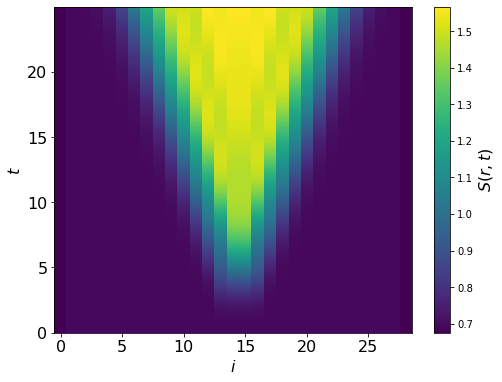

In [71]:
plt.figure(figsize=(8, 6))
t = np.arange(0,t_final,dt)
r = np.arange(0, len(S[1]), 1)
print(np.array(S).shape)
print(r.shape)
colorplot(r, t, np.array(S).T)
plt.xlabel("$i$", fontsize=16)
plt.ylabel("$t$", fontsize=16)
plt.colorbar().set_label("$S(r, t)$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

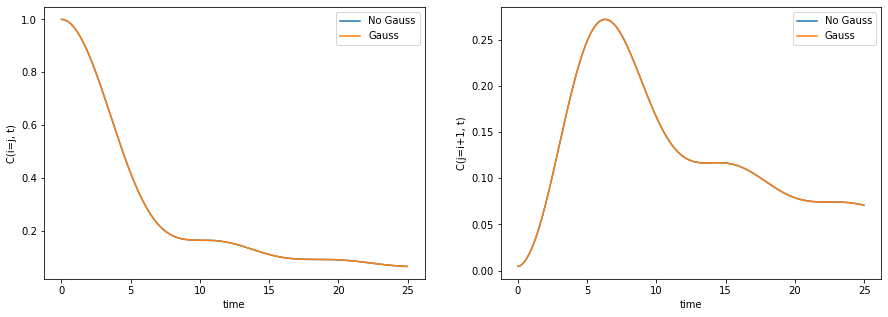

In [66]:
sigma=100 # no gauss needed, Apparently No Gibbs oscillations 

t, k_array, ome_array, C_gauss, C_Fourier_time, C_Fourier_space = fourier_space_time_2(C_positive, t_final, dt, L, sigma)

(30, 1250)
(30,)
1.0


(array([-5.,  0.,  5., 10., 15., 20., 25.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

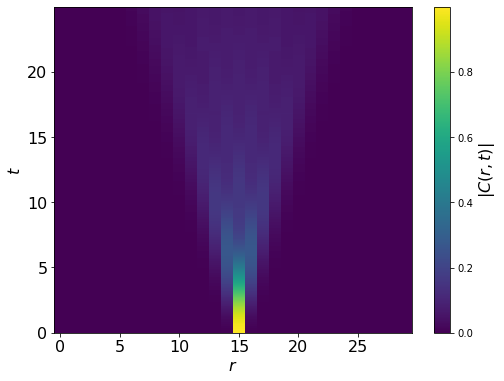

In [70]:
plt.figure(figsize=(8, 6))
t = np.arange(0,t_final,dt)
r = np.arange(0, len(S[1])+1, 1)
print(np.array(C_positive).shape)
print(r.shape)
colorplot(r, t, np.array(abs((C_positive))))
plt.xlabel("$r$", fontsize=16)
plt.ylabel("$t$", fontsize=16)
plt.colorbar().set_label("$|C(r, t)|$", fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

0.2094395102393195


(2.0, 6.0)

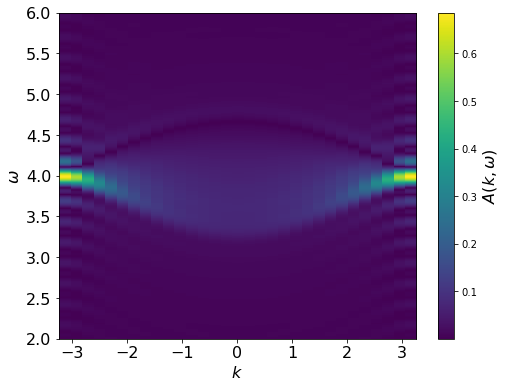

In [69]:
plt.figure(figsize=(8, 6))
colorplot(k_array, ome_array, abs((C_Fourier_space.T)))
plt.xlabel("$k$", fontsize=16)
plt.ylabel("$\\omega$", fontsize=16)
plt.colorbar().set_label("$A(k, \\omega)$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(2, 6)

### d) g=0.2, J=1, h=0.1, L=30, t=25  --- Longitudinal Field

In [42]:
L=30
J=1
g=0.2
h=0.1
dt=0.2
t_final=25
sigma = 0.5 

E, psi, model = TLFIM_TEBD_gs_finite(L, J, g, h)

finite TEBD, (imaginary time evolution)
L=30, J=1.0, g=0.20
dt = 0.10000: E = -32.3034949222838
dt = 0.01000: E = -32.3035779409171
dt = 0.00100: E = -32.3035866244865
dt = 0.00010: E = -32.3035874964951
dt = 0.00001: E = -32.3035875837022
final bond dimensions:  [2, 4, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 4, 2]


In [43]:
dt=0.01

C_positive, S = time_correlation(psi, model, E, sigmay, sigmay, L//2, t_final, dt)

(30, 2500)
(30,)
1.0


(array([-5.,  0.,  5., 10., 15., 20., 25.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

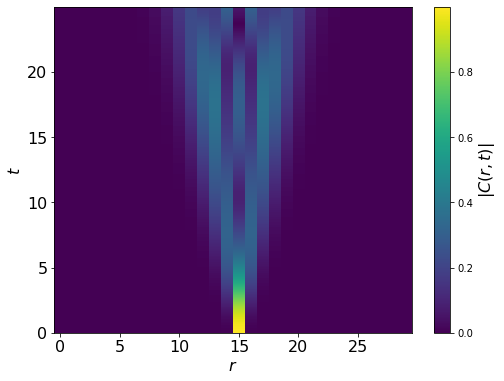

In [45]:
plt.figure(figsize=(8, 6))
t = np.arange(0,t_final,dt)
r = np.arange(0, len(S[1])+1, 1)
print(np.array(C_positive).shape)
print(r.shape)
colorplot(r, t, np.array(abs((C_positive))))
plt.xlabel("$r$", fontsize=16)
plt.ylabel("$t$", fontsize=16)
plt.colorbar().set_label("$|C(r, t)|$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

(2500, 29)
(29,)
1.0


(array([-5.,  0.,  5., 10., 15., 20., 25.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

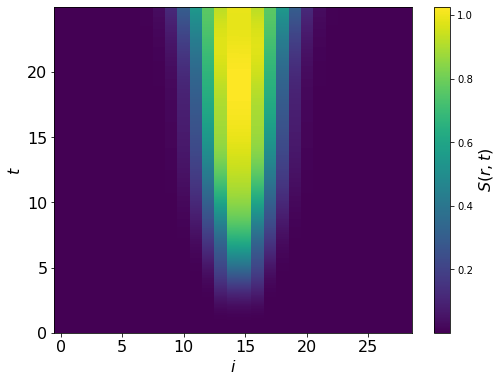

In [46]:
plt.figure(figsize=(8, 6))
t = np.arange(0,t_final,dt)
r = np.arange(0, len(S[1]), 1)
print(np.array(S).shape)
print(r.shape)
colorplot(r, t, np.array(S).T)
plt.xlabel("$i$", fontsize=16)
plt.ylabel("$t$", fontsize=16)
plt.colorbar().set_label("$S(r, t)$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

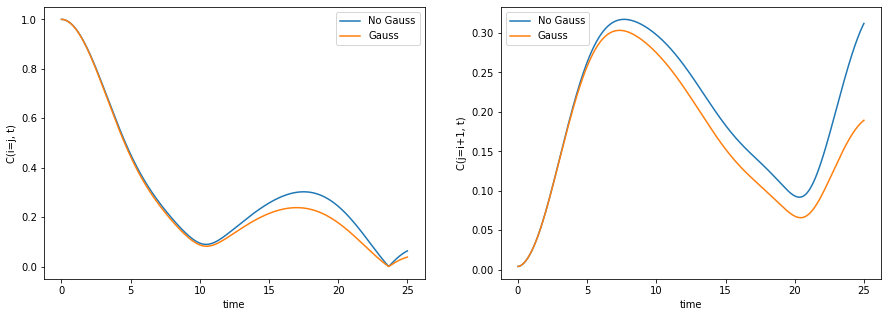

In [48]:
sigma=0.01

t, k_array, ome_array, C_gauss, C_Fourier_time, C_Fourier_space = fourier_space_time_2(C_positive, t_final, dt, L, sigma)

0.2094395102393195


(array([1., 2., 3., 4., 5., 6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

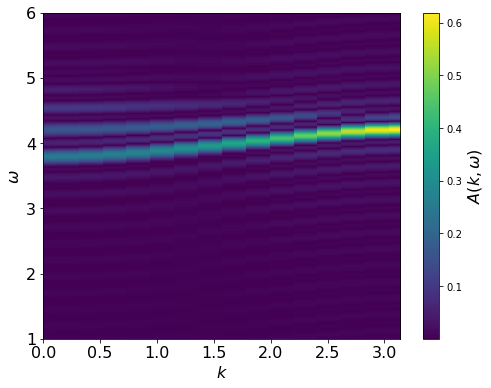

In [50]:
plt.figure(figsize=(8, 6))
colorplot(k_array, ome_array, abs(np.real(C_Fourier_space.T)))
plt.xlabel("$k$", fontsize=16)
plt.ylabel("$\\omega$", fontsize=16)
plt.colorbar().set_label("$A(k, \\omega)$", fontsize=16)
plt.xticks(fontsize=16)
plt.xlim(0, np.pi)
plt.ylim(1, 6)
plt.yticks(fontsize=16)

0.2094395102393195


(array([1., 2., 3., 4., 5., 6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

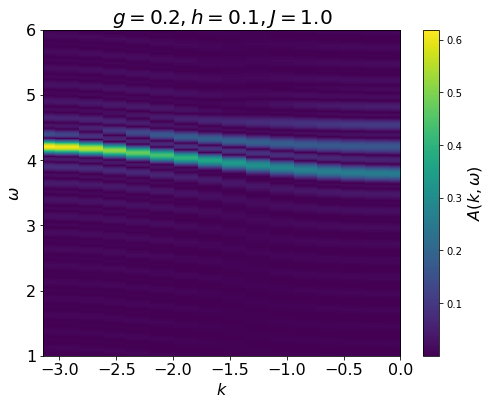

In [51]:
plt.figure(figsize=(8, 6))

colorplot(k_array, ome_array, abs(np.real(C_Fourier_space.T)))
plt.xlabel("$k$", fontsize=16)
plt.ylabel("$\\omega$", fontsize=16)
plt.colorbar().set_label("$A(k, \\omega)$", fontsize=16)
plt.title("$g={g:.1f}, h={h:.1f},  J={J:.1f}$".format(g=g, h=h, J=J), fontsize=20)
plt.xticks(fontsize=16)
plt.xlim(-np.pi, 0)
plt.ylim(1, 6)
plt.yticks(fontsize=16)

In [58]:
k_new = k_array+np.pi
C_final = np.zeros((len(k_new), len(ome_array)), dtype=complex)

31
[4.44089210e-16 2.09439510e-01 4.18879020e-01 6.28318531e-01
 8.37758041e-01 1.04719755e+00 1.25663706e+00 1.46607657e+00
 1.67551608e+00 1.88495559e+00 2.09439510e+00 2.30383461e+00
 2.51327412e+00 2.72271363e+00 2.93215314e+00 3.14159265e+00
 3.35103216e+00 3.56047167e+00 3.76991118e+00 3.97935069e+00
 4.18879020e+00 4.39822972e+00 4.60766923e+00 4.81710874e+00
 5.02654825e+00 5.23598776e+00 5.44542727e+00 5.65486678e+00
 5.86430629e+00 6.07374580e+00 6.28318531e+00]


In [59]:
for i in range(len(k_new)):
    if i<len(k_new)/2:
        C_final[i, :] = C_Fourier_space.T[i+15, :]
    else:
        C_final[i, :] = C_Fourier_space.T[i-15, :]
#print(k_fin.shape)
#print(C_final)

0.20943951023931953


(array([1., 2., 3., 4., 5., 6., 7.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

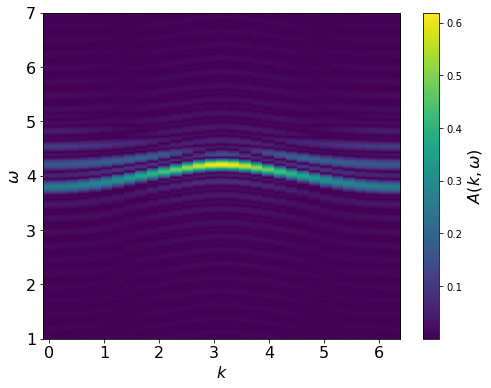

In [62]:
plt.figure(figsize=(8, 6))
colorplot(k_new, ome_array, abs(np.real(C_final)))
plt.xlabel("$k$", fontsize=16)
plt.ylabel("$\\omega$", fontsize=16)
plt.colorbar().set_label("$A(k, \\omega)$", fontsize=16)
plt.xticks(fontsize=16)
plt.ylim(1, 7)
plt.yticks(fontsize=16)